In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import emcee
import corner
from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap,
                               get_mismatch,
                               get_fundamental_frequencies,
                               get_separatrix,
                               get_mu_at_t,
                               get_p_at_t,
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase
import time
from multiprocessing import Pool



In [2]:
'''这个是测量参数'''
dirc_fitting_para = {}
dirc_fitting_para[(0,2,0)] = [3.1565086e-18,1.1387493e-10,1.5821040e-02,0]
dirc_fitting_para[(0,2,1)] = [2.8522272e-18,1.2294423e-10,2.0088489e-02,0]
dirc_fitting_para[(0,2,2)] = [3.2607450e-18,1.2865984e-10,2.4280721e-02,0]

dirc_fitting_para[(1,2,0)] = [5.1510341e-18,1.4194585e-10,1.6635661e-02,0]
dirc_fitting_para[(1,2,1)] = [6.5289275e-18,1.3719657e-10,2.0974698e-02,0]
dirc_fitting_para[(1,2,2)] = [4.7707882e-18,1.4990563e-10,2.5387326e-02,0]

dirc_fitting_para[(2,2,0)] = [7.9051286e-17,1.5071256e-10,1.6794424e-02,0]
dirc_fitting_para[(2,2,1)] = [5.2510786e-17,6.4871200e-11,1.9448126e-02,0]
dirc_fitting_para[(2,2,2)] = [5.8859786e-17,3.6208758e-11,2.3993800e-02,0]


'''这个是信号参数参数'''
# dirc_fitting_para = {}
# dirc_fitting_para[(0,2,0)] = [3.1565086e-18,1.1387493e-10,1.5821040e-02,0]
# dirc_fitting_para[(0,2,1)] = [2.8522272e-18,1.2294423e-10,2.0088489e-02,0]
# dirc_fitting_para[(0,2,2)] = [3.2607450e-18,1.2865984e-10,2.43569157e-02,0]

# dirc_fitting_para[(1,2,0)] = [5.1510341e-18,1.4194585e-10,1.6635661e-02,0]
# dirc_fitting_para[(1,2,1)] = [6.5289275e-18,1.3719657e-10,2.0974698e-02,0]
# dirc_fitting_para[(1,2,2)] = [4.7707882e-18,1.4990563e-10,2.52667880e-02,0]

# dirc_fitting_para[(2,2,0)] = [7.9051286e-17,1.5071256e-10,1.6794424e-02,0]
# dirc_fitting_para[(2,2,1)] = [5.2510786e-17,6.4871200e-11,1.9448126e-02,0]
# dirc_fitting_para[(2,2,2)] = [5.8859786e-17,3.6208758e-11,2.63802470e-02,0]



txt_all='the0个片段220模式：$\ddot{\omega}_0=3.16e-18_{-5.42e-19}^{+4.91e-19}$,$\dot{\omega}_0=1.14e-10_{-2.32e-12}^{+2.59e-12}$,$\omega_0=1.58e-02_{-3.48e-06}^{+3.16e-06}$\
the0个片段221模式：$\ddot{\omega}_0=2.85e-18_{-3.31e-19}^{+3.20e-19}$，$\dot{\omega}_0=1.23e-10_{-1.54e-12}^{+1.61e-12}$，$\omega_0=2.01e-02_{-2.24e-06}^{+2.15e-06}$\
the0个片段222模式：$\vec{\omega}_0=3.26e-18_{-3.75e-19}^{+3.94e-19}$,$\dot{\omega}_0=1.29e-10_{-1.91e-12}^{+1.85e-12}$,$\omega_0=2.43e-02_{-2.57e-06}^{+2.68e-06}$\
the1个片段220模式：$\bar{\omega}_0=5.15e-18_{-4.70e-19}^{+5.55e-19}$,$\dot{\omega}_0=1.42e-10_{-2.70e-12}^{+2.23e-12}$,$\omega_0=1.66e-02_{-8.08e-05}^{+3.68e-06}$\
the1个片段221模式:$\bar{\omega}_0=6.53e-18_{-4.39e-19}^{+9.73e-19}$,$\dot{\omega}_0=1.37e-10_{-6.22e-12}^{+2.18e-12}$,$\omega_0=2.10e-02_{-3.05e-06}^{+1.27e-05}$\
the1个片段222模式:$\ddot{\omega}_0=4.77e-18_{-3.19e-19}^{+3.37e-19}-19$,$\dot{\omega}_0=1.50e-10_{-1.59e-12}^{+1.46e-12}$,$\omega_0=2.54e-02_{-1.84e-06}^{+1.97e-06}$\
the2个片段220模式:$\ddot{\omega}_0=7.91e-17_{-6.36e-17}^{+1.09e-16}$,$\dot{\omega}_0=1.51e-10_{-2.34e-10}^{+4.44e-11}$,$\omega_0=1.68e-02_{-6.17e-04}^{+1.03e-03}$\
the2个片段221模式:$\ddot{\omega}_0=5.25e-17_{-4.55e-17}^{+1.44e-16}$,$\dot{\omega}_0=6.49e-11_{-1.55e-10}^{+1.06e-10}$,$\omega_0=1.94e-02_{-1.44e-03}^{+3.64e-03}$\
the2个片段222模式:$\ddot{\omega}_0=5.89e-17_{-4.08e-17}^{+1.03e-16}$,$\dot{\omega}_0=3.62e-11_{-1.21e-10}^{+1.30e-10}$,$\omega_0=2.40e-02_{-9.56e-04}^{+2.37e-03}$'


'''获取上下边界'''

l_txt = txt_all.split('the')

dirc_up_bond = {}
dirc_low_bond = {}


for jjj in range(len(l_txt)):
    if jjj != 0:
        list_line_one  = l_txt[jjj].split('$')
        list_one_up = []
        list_one_low = []
        the_time_segmet = list_line_one[0][0]
        harmonic_mode = list_line_one[0][4:7]
        for i in [1,3,5]:
            string_low_bond = list_line_one[i].split('_{')[-1].split('}^{')[0]
            value_low_bond = float(string_low_bond)
            string_up_bond = list_line_one[i].split('^{')[-1].split('}^{')[0].split('}')[0]
            value_up_bond = float(string_up_bond)
            list_one_up.append(value_up_bond)
            list_one_low.append(value_low_bond)

        dirc_up_bond[f'({the_time_segmet},{harmonic_mode})'] = list_one_up
        dirc_low_bond[f'({the_time_segmet},{harmonic_mode})'] = list_one_low


print(dirc_up_bond)
print(dirc_low_bond)



{'(0,220)': [4.91e-19, 2.59e-12, 3.16e-06], '(0,221)': [3.2e-19, 1.61e-12, 2.15e-06], '(0,222)': [3.94e-19, 1.85e-12, 2.68e-06], '(1,220)': [5.55e-19, 2.23e-12, 3.68e-06], '(1,221)': [9.73e-19, 2.18e-12, 1.27e-05], '(1,222)': [3.37e-19, 1.46e-12, 1.97e-06], '(2,220)': [1.09e-16, 4.44e-11, 0.00103], '(2,221)': [1.44e-16, 1.06e-10, 0.00364], '(2,222)': [1.03e-16, 1.3e-10, 0.00237]}
{'(0,220)': [-5.42e-19, -2.32e-12, -3.48e-06], '(0,221)': [-3.31e-19, -1.54e-12, -2.24e-06], '(0,222)': [-3.75e-19, -1.91e-12, -2.57e-06], '(1,220)': [-4.7e-19, -2.7e-12, -8.08e-05], '(1,221)': [-4.39e-19, -6.22e-12, -3.05e-06], '(1,222)': [-3.19e-19, -1.59e-12, -1.84e-06], '(2,220)': [-6.36e-17, -2.34e-10, -0.000617], '(2,221)': [-4.55e-17, -1.55e-10, -0.00144], '(2,222)': [-4.08e-17, -1.21e-10, -0.000956]}


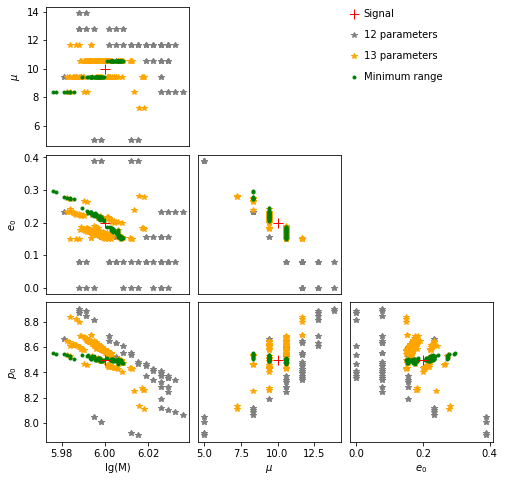

In [18]:
_list = []
for i in range(len(array_num_fit_para_large)):
    if array_num_fit_para_large[i,4] > 11:
        _list.append(array_num_fit_para_large[i,:4])
range_12 = np.array(_list)


_list = []
for i in range(len(array_num_fit_para_large)):
    if array_num_fit_para_large[i,4] > 12:
        _list.append(array_num_fit_para_large[i,:4])

range_13 = np.array(_list)



_list = []
for i in range(len(array_num_fit_para_small)):
    if array_num_fit_para_small[i,4] > 12:
        _list.append(array_num_fit_para_small[i,:4])

range_14 = np.array(_list)

_list = []
for i in range(len(array_num_fit_para_small)):
    if array_num_fit_para_small[i,4] > 11 and array_num_fit_para_small[i,7] == 1 and array_num_fit_para_small[i,7] == 1 \
    and array_num_fit_para_small[i,10] == 1 and array_num_fit_para_small[i,15] == 1 :
        _list.append(array_num_fit_para_small[i,:4])

        
range_15 = np.array(_list)


plt.figure(figsize=(8,8))
plt.subplots_adjust(wspace=0.06,hspace=0.06)
plt.subplot(3,3,1)
plt.plot(range_12[:,0],range_12[:,1],linestyle='',marker='*',c='gray')
plt.plot(range_14[:,0],range_14[:,1],linestyle='',marker='*',c='orange')
plt.plot(range_15[:,0],range_15[:,1],linestyle='',marker='.',c= 'green')
plt.plot(6,10,linestyle=' ',c='r',marker='+',markersize=10)
plt.ylabel(r'$\mu$')
plt.xticks([])
plt.subplot(3,3,3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(0.03,0.95,linestyle='',c='r',marker='+',markersize=10)
plt.text(0.1,0.93,'Signal')
plt.plot(0.03,0.8,linestyle='',marker='*',c='gray')
plt.text(0.1,0.78,'12 parameters')
plt.plot(0.03,0.65,linestyle='',marker='*',c='orange')
plt.text(0.1,0.63,'13 parameters')
plt.plot(0.03,0.5,linestyle='',marker='.',c= 'green')
plt.text(0.1,0.48,'Minimum range')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.subplot(3,3,4)
plt.plot(range_12[:,0],range_12[:,2],linestyle='',marker='*',c='gray')
plt.plot(range_14[:,0],range_14[:,2],linestyle='',marker='*',c='orange')
plt.plot(range_15[:,0],range_15[:,2],linestyle='',marker='.',c= 'green')
plt.plot(6,0.2,linestyle=' ',c='r',marker='+',markersize=10)
plt.ylabel(r'$e_{0}$')
plt.xticks([])
plt.subplot(3,3,5)
plt.plot(range_12[:,1],range_12[:,2],linestyle='',marker='*',c='gray')
plt.plot(range_14[:,1],range_14[:,2],linestyle='',marker='*',c='orange')
plt.plot(range_15[:,1],range_15[:,2],linestyle='',marker='.',c= 'green')
plt.plot(10,0.2,linestyle=' ',c='r',marker='+',markersize=10)
plt.xticks([])
plt.yticks([])
plt.subplot(3,3,7)
plt.plot(range_12[:,0],range_12[:,3],linestyle='',marker='*',c='gray')
plt.plot(range_14[:,0],range_14[:,3],linestyle='',marker='*',c='orange')
plt.plot(range_15[:,0],range_15[:,3],linestyle='',marker='.',c= 'green')
plt.plot(6,8.5,linestyle=' ',c='r',marker='+',markersize=10)
plt.xlabel('lg(M)')
plt.ylabel(r'$p_{0}$')
plt.subplot(3,3,8)
plt.plot(range_12[:,1],range_12[:,3],linestyle='',marker='*',c='gray')
plt.plot(range_14[:,1],range_14[:,3],linestyle='',marker='*',c='orange')
plt.plot(range_15[:,1],range_15[:,3],linestyle='',marker='.',c= 'green')
plt.plot(10,8.5,linestyle=' ',c='r',marker='+',markersize=10)
plt.xlabel(r'$\mu$')
plt.yticks([])
plt.subplot(3,3,9)
plt.plot(range_12[:,2],range_12[:,3],linestyle='',marker='*',c='gray')
plt.plot(range_14[:,2],range_14[:,3],linestyle='',marker='*',c='orange')
plt.plot(range_15[:,2],range_15[:,3],linestyle='',marker='.',c= 'green')
plt.plot(0.2,8.5,linestyle=' ',c='r',marker='+',markersize=10)
plt.xlabel(r'$e_{0}$')
plt.yticks([])

plt.savefig('./fit_to_physics.pdf',dpi =1000)



